In [1]:
import numpy as np
import vanilla_LA.potentials
import vanilla_LA.metropolis_hastings as mh
import matplotlib.pyplot as plt
import scipy.stats

%load_ext autoreload
%autoreload 2

In [2]:
# assuming traj is a trajectory in the 2D plane
def plot_2D_evolution(H,traj,**kwargs):
    x_track = [v[0] for v in traj]
    y_track = [v[1] for v in traj]
    
    # visualize our potential
    padding = 0.1
    x = np.arange(min(x_track)-padding, max(x_track)+padding, 0.1)
    y = np.arange(min(y_track)-padding, max(y_track)+padding, 0.1)
    
    F = np.full((y.size,x.size),np.nan)
    G = np.full((y.size,x.size,2),np.nan)
    for ii in range(y.size):
        for jj in range(x.size):
            v = np.array([x[jj],y[ii]])
            F[ii,jj] = H.eval(v)
            G[ii,jj,:] = H.gradient(v)
            
    xx,yy = np.meshgrid(x,y)
    h = plt.contourf(xx,yy,F,alpha=0.5,cmap='gray')
    plt.title('f')
    plt.plot(x_track,y_track,'b')
    plt.plot(x_track[0],y_track[0],'r',marker="x", markersize=10)
    plt.show()
    
    # default behavior is to plot gradient quiverplot
    if 'gradient' in kwargs and not kwargs['gradient']:
        return
    else:
        fig, ax = plt.subplots(figsize=(15,15))
        h = plt.contourf(xx,yy,F,alpha=0.2)
        q = ax.quiver(xx, yy, G[:,:,0], G[:,:,1])
        plt.title('|grad|')
        plt.show()
    
def plot_potential(H,lims,**kwargs):
    # visualize our potential
    padding = 0.1
    x = np.linspace(lims[0]-padding, lims[1]+padding, 20)
    y = np.linspace(lims[0]-padding, lims[1]+padding, 20)
    
    F = np.full((y.size,x.size),np.nan)
    G = np.full((y.size,x.size,2),np.nan)
    for ii in range(y.size):
        for jj in range(x.size):
            v = np.array([x[jj],y[ii]])
            F[ii,jj] = H.eval(v)
            G[ii,jj,:] = H.gradient(v)
            
    xx,yy = np.meshgrid(x,y)
    h = plt.contourf(xx,yy,F)
    plt.title('f')
    plt.colorbar()
    plt.show()
    
    xx,yy = np.meshgrid(x,y)
    h = plt.contourf(xx,yy,np.log(F))
    plt.title('log(f)')
    plt.colorbar()
    plt.show()
    
    # default behavior is to plot gradient quiverplot
    if 'gradient' in kwargs and not kwargs['gradient']:
        return
    else:
        fig, ax = plt.subplots(figsize=(15,15))
        h = plt.contourf(xx,yy,F,alpha=0.2)
        q = ax.quiver(xx, yy, G[:,:,0], G[:,:,1])
        plt.title('|grad|')
        plt.show()
        
def evaluate_gaussian(H,traj,**kwargs):
    # Create observations x dimension matrix
    data = np.asarray(traj)
    Mu = H.mu
    Sigma=H.cov

    if 'verbose' in kwargs and kwargs['verbose']:
        for mix_time in [0,int(np.floor(len(traj)/2))]:
            mean = np.mean(data[mix_time:,:], axis=0)
            # rowvar=False tells np.cov that rows are observations and
            # columns are variables, rather than vice versa
            cov = np.cov(data[mix_time:,:],rowvar=False)

            mean_rel_error = np.linalg.norm(Mu-mean)#/np.linalg.norm(Mu)
            cov_rel_error = np.linalg.norm(Sigma-cov,ord='fro')/np.linalg.norm(Sigma,ord='fro')
            print('Throwing out first ',mix_time,' terms:')
            print('     Estimated mean L2 error =',mean_rel_error)
            print('     Estimated cov relative error of',cov_rel_error)
    return np.mean(data, axis=0),np.cov(data,rowvar=False)

def aggregate_gaussian_trials(H,update_rule,num_trials,x_0,**kwargs):
    Mu = H.mu
    Sigma=H.cov
    
    mu_list = list()
    cov_list = list()
    for _ in range(num_trials):
        traj = mh.metropolis(potential=H,update_rule=update_rule,
                         initial_point=x_0,**kwargs)
        est_mu,est_cov = evaluate_gaussian(H,traj)
        
        mean_rel_error = np.linalg.norm(Mu-est_mu)#/np.linalg.norm(Mu)
        cov_rel_error = np.linalg.norm(Sigma-est_cov,ord='fro')/np.linalg.norm(Sigma,ord='fro')
        mu_list.append(mean_rel_error)
        cov_list.append(cov_rel_error)
        
    return np.mean(mu_list),np.mean(cov_list)
    #np.mean(np.asarray(mu_list),axis=0),np.mean(np.asarray(cov_list),axis=0)
     
    

# define our potential function:
a simple 2D gaussian well

In [3]:
Sigma = np.array([[ 1. , -.5], [-0.5,  1.5]])
Mu = np.array([0,0])

H = vanilla_LA.potentials.Gaussian(ambient_dim=2,
                                   proper_dim = 2,mu = Mu,cov=Sigma)

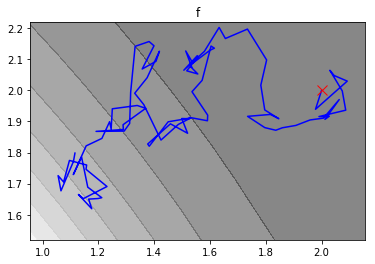

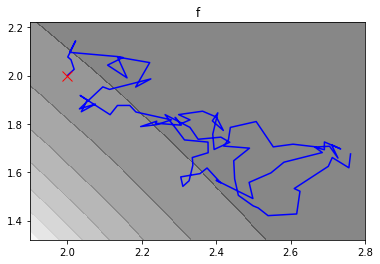

(array([2.35285025, 1.76400736]), array([[ 0.04534688, -0.02713779],
        [-0.02713779,  0.02990816]]))

In [4]:
x_0 = np.array([2.0,2.0])
T = 100

# compare how quickly langevin converges to our well vs the naive 
# gaussian
traj = mh.metropolis(potential=H,update_rule=mh.langevin,
                     initial_point=x_0,max_steps=T,step_size = 0.05)
plot_2D_evolution(H,traj,gradient=False)
evaluate_gaussian(H,traj)


traj = mh.metropolis(potential=H,update_rule=mh.gaussian,
                     initial_point=x_0,max_steps=T,radius = 0.05)
plot_2D_evolution(H,traj,gradient=False)
evaluate_gaussian(H,traj)

In [350]:
x_0 = np.array([2.0,2.0])
T = 10000
num_trials=10
print('Truth:')
print('     mu = ',H.mu)
print('     cov = \n',H.cov)

# compare aggregate performance
mu_est,cov_est = aggregate_gaussian_trials(H,mh.langevin,num_trials,x_0,
                          max_steps=T,step_size = 0.05)
print('Langevin:')
print('     mu_est = ',mu_est)
print('     cov_est = \n',cov_est)

mu_est,cov_est = aggregate_gaussian_trials(H,mh.gaussian,num_trials,x_0,
                          max_steps=T,radius = 0.05)
print('Gaussian:')
print('     mu_est = ',mu_est)
print('     cov_est = \n',cov_est)




Truth:
     mu =  [0 0]
     cov = 
 [[ 1.  -0.5]
 [-0.5  1.5]]
Langevin:
     mu_est =  0.24449957056159755
     cov_est = 
 0.6421926535570288
Gaussian:
     mu_est =  0.37883584752317645
     cov_est = 
 0.44545297727772776


In [230]:
# We can compare how well our samples recover the true distribution
# it takes some time for our sampler to converge to the distribution:
# you can either (a) estimate the number of time steps till mixing
# and throw those out, or (b) run your process a loooooong time and
# hope that it spends more time in the mixed or near-mixed state

data = np.asarray(traj)

for mix_time in [0,50,500,5000,50000,80000,90000]:
    mean = np.mean(data[mix_time:,:], axis=0)
    cov = np.cov(data[mix_time:,:], rowvar=0)
    if mix_time==0:
        print(mean)
        print(cov)

    mean_rel_error = np.linalg.norm(Mu-mean)#/np.linalg.norm(Mu)
    cov_rel_error = np.linalg.norm(Sigma-cov,ord='fro')/np.linalg.norm(Sigma,ord='fro')
    print('Throwing out first ',mix_time,' terms:')
    print('     Estimated mean L2 error =',mean_rel_error)
    print('     Estimated cov relative error of',cov_rel_error)


[-0.00346202  0.0044003 ]
[[ 0.52136836 -0.13236374]
 [-0.13236374  0.66201799]]
Throwing out first  0  terms:
     Estimated mean L2 error = 0.005598947847383527
     Estimated cov relative error of 0.5660659415822998
Throwing out first  50  terms:
     Estimated mean L2 error = 0.005500542772141129
     Estimated cov relative error of 0.5660418344208349
Throwing out first  500  terms:
     Estimated mean L2 error = 0.006073787930304812
     Estimated cov relative error of 0.5658535374084629
Throwing out first  5000  terms:
     Estimated mean L2 error = 0.005114236055099721
     Estimated cov relative error of 0.5652057735754787
Throwing out first  50000  terms:
     Estimated mean L2 error = 0.0016595334579462243
     Estimated cov relative error of 0.5704912472442913
Throwing out first  80000  terms:
     Estimated mean L2 error = 0.008579703848199898
     Estimated cov relative error of 0.570329488095768
Throwing out first  90000  terms:
     Estimated mean L2 error = 0.0178184431

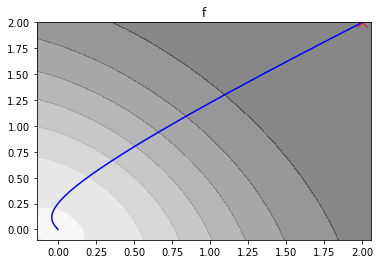

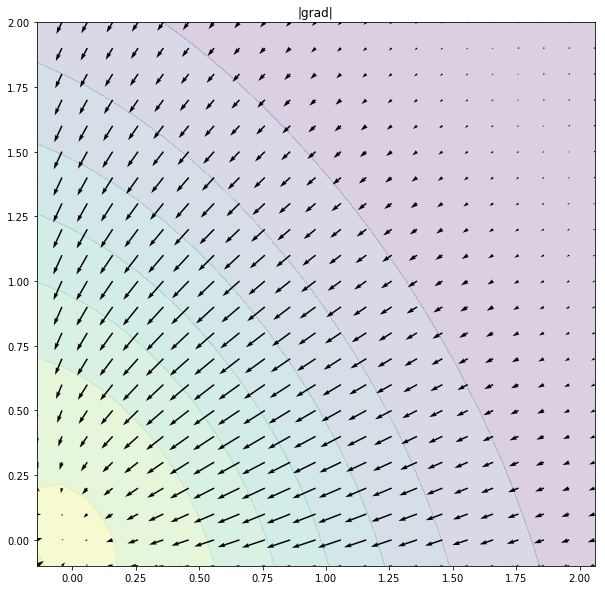

'traj = mh.metropolis(potential=H,update_rule=mh.gaussian,\n                     initial_point=x_0,max_steps=T,radius = 0.05)\nplot_2D_evolution(H,traj)'

In [281]:
x_0 = np.array([2.0,2.0])
T = 1000

# compare how quickly langevin converges to our well vs the naive 
# gaussian
traj = mh.metropolis(potential=H,update_rule=mh.langevin,
                     initial_point=x_0,max_steps=T,step_size = 1)
plot_2D_evolution(H,traj)

"""traj = mh.metropolis(potential=H,update_rule=mh.gaussian,
                     initial_point=x_0,max_steps=T,radius = 0.05)
plot_2D_evolution(H,traj)"""

# Double-well experiments

# Something's wrong with the gradient in the double well--I'm not sure what yet.
Langevin dynamics are also better at exploring the space (i.e. not getting trapped in local minima) than vanilla

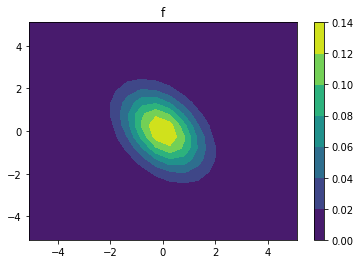

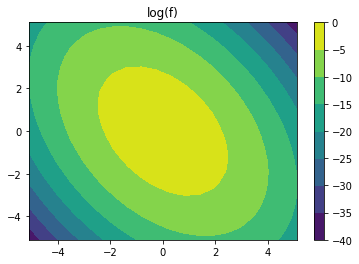

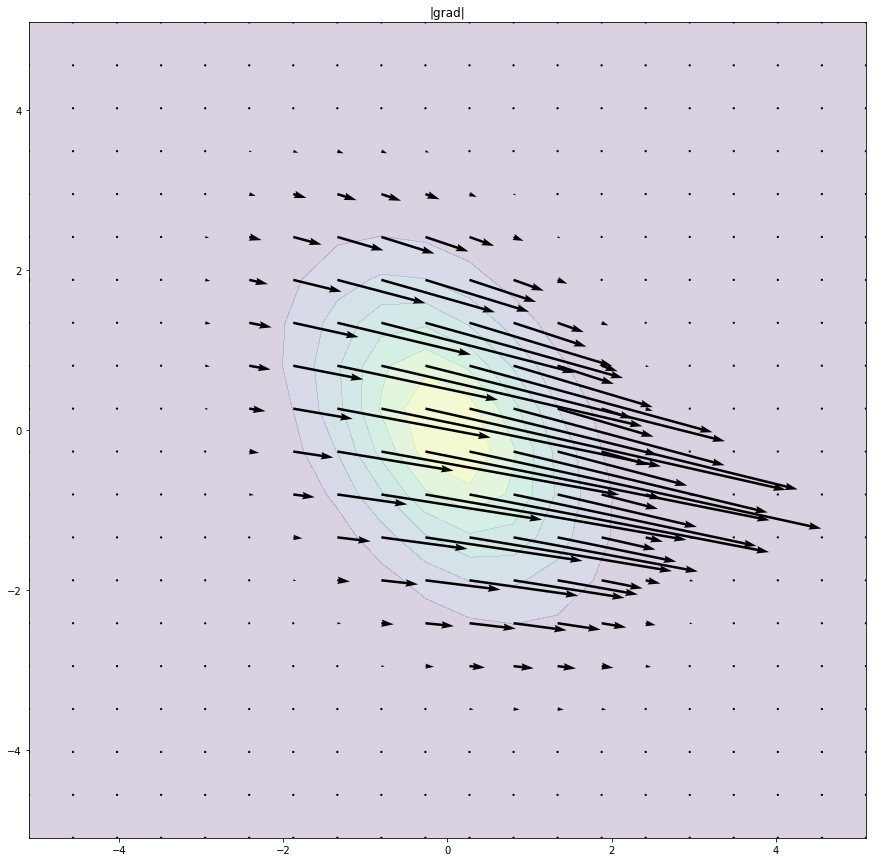

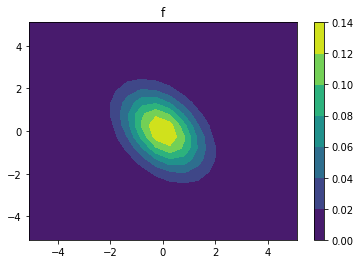

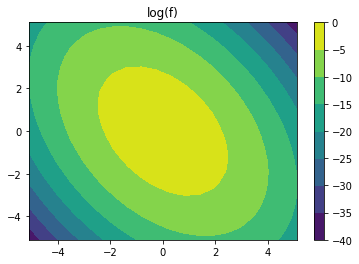

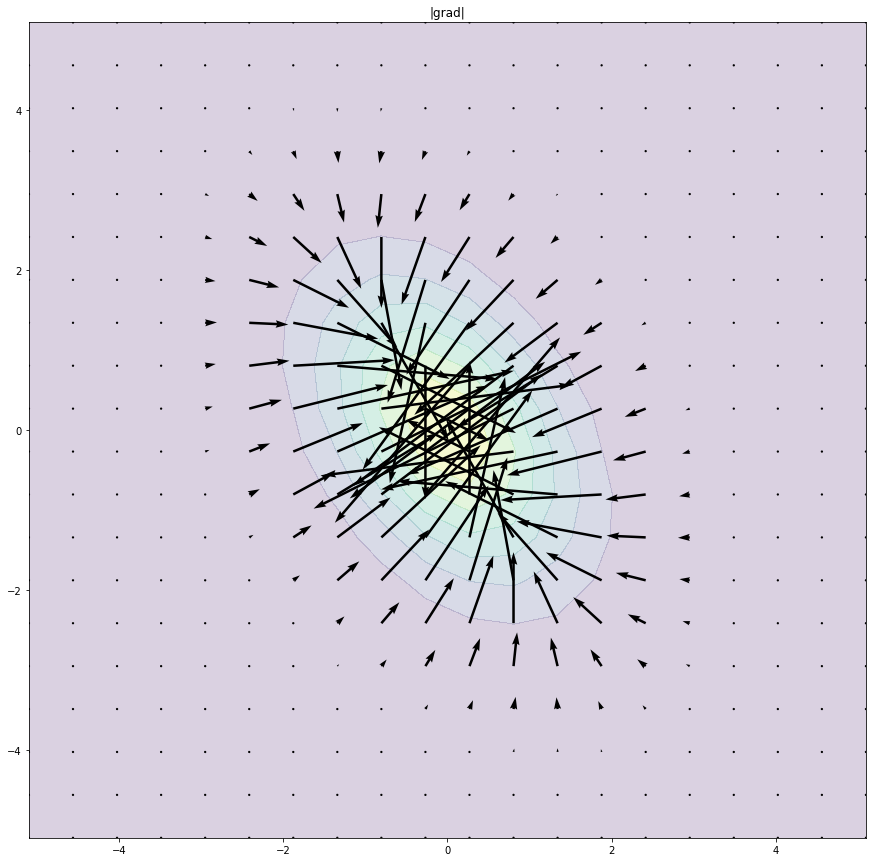

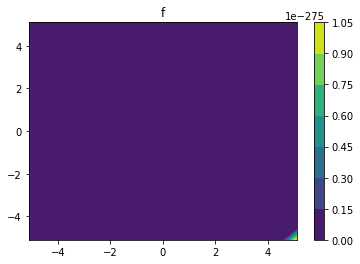

/Users/adeladepavia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


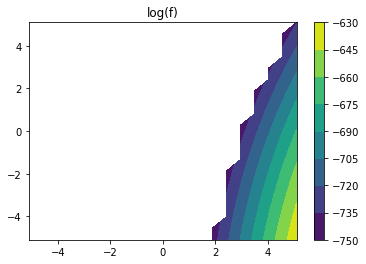

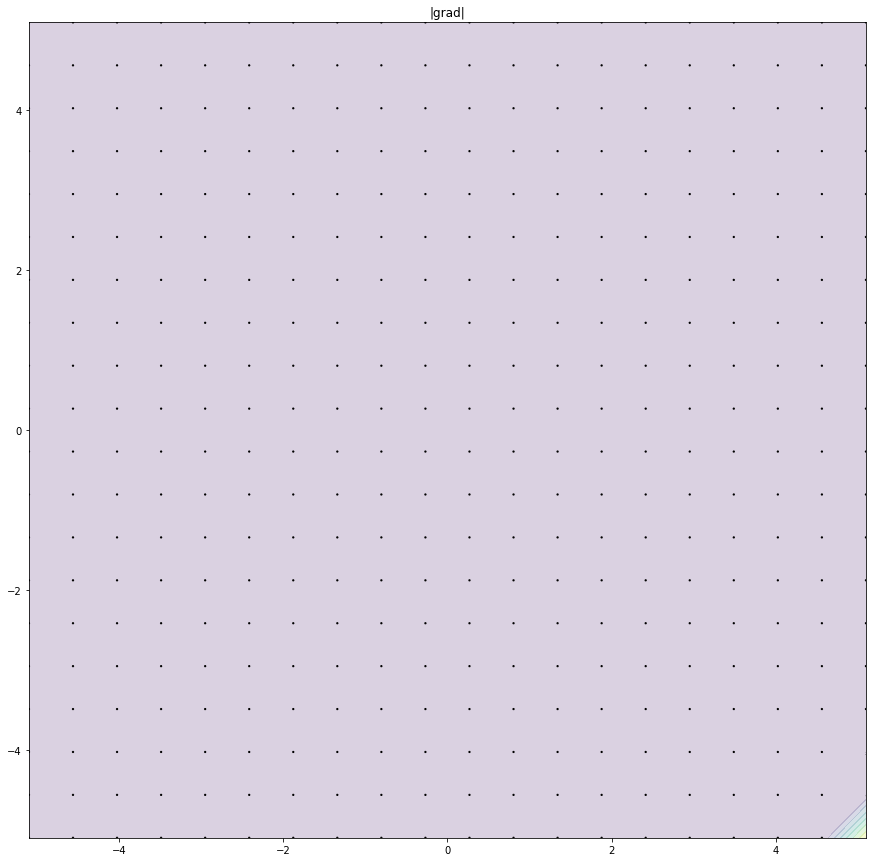

In [291]:
Sigma = np.array([[ 1. , -.5], [-0.5,  1.5]])
Mu = np.array([0,0])

Sigma_2 = np.array([[ 1. , -.5], [-0.5,  1.5]])
Mu_2 = np.array([40,-30])

gauss_1 = (Mu,Sigma)
gauss_2 = (Mu_2,Sigma_2)
H = vanilla_LA.potentials.Double_well(ambient_dim=2, proper_dim = 2,
                                      gauss_1 = (Mu,Sigma),
                                      gauss_2=(Mu_2,Sigma_2))

plot_potential(H,[-5,5])

H = vanilla_LA.potentials.Gaussian(ambient_dim=2,
                                   proper_dim = 2,mu = Mu,cov=Sigma)

plot_potential(H,[-5,5])

H = vanilla_LA.potentials.Gaussian(ambient_dim=2,
                                   proper_dim = 2,mu = Mu_2,cov=Sigma_2)

plot_potential(H,[-5,5])